# General Description

1. Create Datasets
2. Create AF jobs
3. analyze AF output

## 1. Create Datasets

- read in the human proteome (use reviewed proteins)
- filter for armadillo repeat proteins
- filter for Transcription Factor proteins
- Filter Transcription Factors for disordered Proteins
- STRING database matching

### Library imports and helper functions

In [ ]:
import pandas as pd
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from typing import List, Tuple, Dict, Any, Union, Optional, Set

def contains_any_annotation(cell_value: Any, annotations_list: List[str]) -> bool:
    """check if any of the annotations are in the column value

    Args:
        cell_value (Any): Cell value from DataFrame column to check
        annotations_list (List[str]): List of annotation strings to check for

    Returns:
        bool: True if any annotation is found in the cell_value, False otherwise
    """
    if pd.isna(cell_value):
        return False
    for annotation in annotations_list:
        if annotation in cell_value:
            return True
    return False

### Constants

In [ ]:
STRING_PATH = '/home/markus/MPI_local/data/STRING/9606.protein.links.full.v12.0.txt_processed.csv'
PROTEOME_PATH = '/home/markus/MPI_local/data/Proteome/uniprotkb_proteome_UP000005640_2025_05_28.tsv'
TF_DATASET_PATH = '/home/markus/MPI_local/data/human_TFs/DatabaseExtract_v_1.01.csv'
ENSEMBL_MAPPING_PATH = '/home/markus/MPI_local/data/Ensembl_mapping/Homo_sapiens.GRCh38.114.uniprot.tsv/hps/nobackup/flicek/ensembl/production/release_dumps/release-114/ftp_dumps/vertebrates/tsv/homo_sapiens/Homo_sapiens.GRCh38.114.uniprot.tsv'
AIUPRED_PATH = '/home/markus/MPI_local/data/AIUPred/AIUPred_data.json'
DISPROT_PATH = '/home/markus/MPI_local/data/DisProt/DisProt_release_2024_12 with_ambiguous_evidences.tsv'
IUPRED3_PATH = '../../iupred3'

### Read in Proteome

In [ ]:
all_proteins = pd.read_csv(PROTEOME_PATH, sep='\t')
reviewed_proteins = all_proteins[all_proteins['Reviewed'] == 'reviewed']

### create Armadillo dataset

In [ ]:
# Filter for Armadillos
## all the interpro IDs that have the word "armadillo" in the description
arm_accs_ipr = [
    'IPR013636',
    'IPR024574',
    'IPR041322',
    'IPR055241',
    'IPR056252',
    'IPR016617',
    'IPR031524',
    'IPR038739',
    'IPR038905',
    'IPR039868',
    'IPR040268',
    'IPR042462',
    'IPR042834',
    'IPR043379',
    'IPR044282',
    'IPR051303',
    'IPR052441',
    'IPR011989',
    'IPR016024',
    'IPR000225',
    'IPR041209',
    'IPR049152',
    'IPR006911'
]

# all pfam accessions that have "armadillo" in the description
arm_accs_pfam = [
    'PF00514.29',
    'PF17822.6',
    'PF08427.15',
    'PF15767.10',
    'PF22915.1',
    'PF04826.19',
    'PF23295.1',
    'PF16629.10',
    'PF18770.7',
    'PF21052.3',
    'PF11841.14',
    'PF14726.11',
    'PF18581.7'
]

# strip version number since it is not included in the uniprot annotation
for i in range(len(arm_accs_pfam)):
    arm_accs_pfam[i] = arm_accs_pfam[i].split(".")[0]
    
# find proteins with "ARM" in their Repeat column
repeat_mask_arm = reviewed_proteins['Repeat'].apply(lambda x: "ARM" in str(x) if pd.notna(x) else False)
print(f"Proteins with 'ARM' in Repeat column: {len(reviewed_proteins[repeat_mask_arm])}")

# Filter rows where InterPro column contains any interpro_annotations
interpro_mask_arm = reviewed_proteins['InterPro'].apply(lambda x: contains_any_annotation(x, arm_accs_ipr))
print(f"Proteins with specified InterPro annotation: {len(reviewed_proteins[interpro_mask_arm])}")

# Filter rows where Pfam column contains any pfam_annotations
pfam_mask_arm = reviewed_proteins['Pfam'].apply(lambda x: contains_any_annotation(x, arm_accs_pfam))
print(f"Proteins with specified Pfam annotation: {len(reviewed_proteins[pfam_mask_arm])}")

# apply filters using OR
armadillo_proteins = reviewed_proteins[interpro_mask_arm | pfam_mask_arm | repeat_mask_arm]

print(f"Found {len(armadillo_proteins)} proteins with armadillo domains")

### Create Transcription Factor dataset (UniProtFilter)

In [ ]:
# def str_tf(x):
#     return "transcription factor" in x.lower()

# def str_t(x):
#     return "transcription" in x.lower()

# # IPR accessions containing "transcription"
# IPR_entries = pd.read_csv("../entry.list", sep="\t")
# tf_accs_ipr = IPR_entries[IPR_entries['ENTRY_NAME'].apply(lambda x: str_t(x))]["ENTRY_AC"].tolist()

# # PFAM accessions containing "transcription factor"
# PFAM_entries = pd.read_csv("../data/pfam_parsed_data.csv", sep=",")
# tf_accs_pfam = PFAM_entries[PFAM_entries['DE'].apply(lambda x: str_t(x))]["AC"].tolist()

# # strip version number since it is not included in the uniprot annotation
# for i in range(len(tf_accs_pfam)):
#     tf_accs_pfam[i] = tf_accs_pfam[i].split(".")[0]

# interpro_mask_tf = reviewed_proteins['InterPro'].apply(lambda x: contains_any_annotation(x, tf_accs_ipr))
# print(f"Proteins with specified InterPro annotation: {len(reviewed_proteins[interpro_mask_tf])}")

# pfam_mask_tf = reviewed_proteins['Pfam'].apply(lambda x: contains_any_annotation(x, tf_accs_pfam))
# print(f"Proteins with specified Pfam annotation: {len(reviewed_proteins[pfam_mask_tf])}")

# txt_mask_tf = reviewed_proteins['Protein names'].apply(lambda x: str_tf(x))
# print(f"Proteins with 'Transcription factor' in the name: {len(reviewed_proteins[txt_mask_tf])}")


# # Combine filters with OR operation
# tf_proteins_uniprot_ds = reviewed_proteins[interpro_mask_tf | pfam_mask_tf | txt_mask_tf]

# print(f"Found {len(tf_proteins_uniprot_ds)} proteins with transcription factor annotation")

### Use existing Transcription Factor dataset

In [ ]:
human_TFs = pd.read_csv(TF_DATASET_PATH)
human_TFs = human_TFs[human_TFs['Is TF?'] == 'Yes']
len(human_TFs)

In [ ]:
ensembl_mapping = pd.read_csv(ENSEMBL_MAPPING_PATH, sep='\t')
ensembl_mapping_swissProt = ensembl_mapping[ensembl_mapping['db_name'] == 'Uniprot/SWISSPROT']

In [ ]:
human_TFs_gids = human_TFs['Ensembl ID'].tolist()

# Use swiss prot accessions to prevent duplicates
human_TF_uniprot_accs = ensembl_mapping_swissProt[ensembl_mapping_swissProt['gene_stable_id'].apply(lambda x: any((id == x) for id in human_TFs_gids))]['xref'].tolist()
print(len(human_TF_uniprot_accs))

tf_proteins_curated_ds = reviewed_proteins[reviewed_proteins['Entry'].apply(lambda x: any((id in x) for id in human_TF_uniprot_accs))]
print(len(tf_proteins_curated_ds))

### Filter disordered transcription factors

#### AIUPred

##### Annotaion

In [ ]:
# API requests (only necessary once, see cache file AIUPRED_PATH)

# url = 'https://aiupred.elte.hu/rest_api'

# AIUPred_data = []
# c = 0
# for acc in tf_proteins_curated_ds['Entry'].tolist():
#     data = {'accession': acc, 'smoothing': 'default'}
#     response = requests.get(url, params=data)
#     if response.status_code == 200:
#         AIUPred_data.append(json.loads(response.text))
#         c += 1
#         if c % 100 == 0:
#             print(c)
#     else:
#         print(f"Failed to fetch data for accession {acc}: {response.status_code}")
        
# with open('AIUPred_data.json', 'a') as json_file:
#     json.dump(AIUPred_data, json_file, indent=2)

In [ ]:
# load cache file
with open(AIUPRED_PATH, 'r') as file:
    AIUPred_df = pd.DataFrame(json.load(file))

##### Filter

In [ ]:
from typing import List, Tuple

def find_subranges(data: List[float], threshold: float, min_length: int) -> List[Tuple[int, int]]:
    """Find continuous subranges in data where values exceed the threshold for at least min_length positions

    Args:
        data (List[float]): List of numerical values to analyze
        threshold (float): Minimum value to be considered part of a subrange
        min_length (int): Minimum length a subrange must have to be included in results

    Returns:
        List[Tuple[int, int]]: List of tuples containing start and end indices of subranges
    """
    subranges = []
    start = None

    for i, value in enumerate(data):
        if value >= threshold:
            if start is None:
                start = i
            # Check if it's the last element or the next element does not exceed x
            if i == len(data) - 1 or data[i + 1] < threshold:
                if i - start + 1 >= min_length:
                    subranges.append((start, i))
                start = None
        else:
            start = None

    return subranges

In [ ]:
MIN_LENGTH_DISORDERED_REGION = 20
AIUPRED_THRESHOLD = 0.9

AIUPred_df['ind_disordered_regions'] = AIUPred_df['AIUPred'].apply(lambda x: find_subranges(x, AIUPRED_THRESHOLD, MIN_LENGTH_DISORDERED_REGION))
AIUPred_df['num_disordered_regions'] = AIUPred_df['ind_disordered_regions'].apply(len)
tf_proteins_curated_ds_AIUpred = tf_proteins_curated_ds.merge(AIUPred_df, left_on='Entry', right_on='accession', how='inner')
tf_proteins_curated_ds_AIUpred_diso = tf_proteins_curated_ds_AIUpred[tf_proteins_curated_ds_AIUpred['num_disordered_regions'] > 0]

print(f'Num proteins before disorder filter: {len(tf_proteins_curated_ds_AIUpred)}')
print(f'Num proteins after disorder filter: {len(tf_proteins_curated_ds_AIUpred_diso)}')


#### IUPred 3

In [ ]:
import sys
sys.path.append(IUPRED3_PATH)
import iupred3_lib

sequence = tf_proteins_curated_ds['Sequence'].iloc[0]
print(sequence)
iupred3_result = iupred3_lib.iupred(sequence, 'long', smoothing='no')
print(iupred3_result[0])

In [ ]:
IUPRED3_THRESHOLD = 0.5

tf_proteins_curated_ds['iupred3'] = tf_proteins_curated_ds['Sequence'].apply(lambda x: iupred3_lib.iupred(x, 'long', smoothing='no')[0])

tf_proteins_curated_ds['num_disordered_regions'] = tf_proteins_curated_ds['iupred3'].apply(lambda x: len(find_subranges(x, IUPRED3_THRESHOLD, MIN_LENGTH_DISORDERED_REGION)))
print(len(tf_proteins_curated_ds[tf_proteins_curated_ds['num_disordered_regions'] > 0]))

#### Disprot

In [ ]:
disprot_df = pd.read_csv(DISPROT_PATH, sep='\t')

# make format the same as in uniprot columns
disprot_df['disprot_id'] = disprot_df['disprot_id'].apply(lambda x: x + ';')

tf_disprot_ids = tf_proteins_curated_ds['DisProt'].dropna().tolist()

disprot_tfs = disprot_df[disprot_df['disprot_id'].apply(lambda x: x in tf_disprot_ids)]

# summarize the rows with the same 'disprot_id': 
# disprot_tfs_sum = 

In [ ]:
tf_proteins_curated_ds_disprot = tf_proteins_curated_ds.merge(disprot_df, how='left', left_on='DisProt', right_on='disprot_id')

In [ ]:
def create_all_pairs(arm_df: pd.DataFrame, tf_df: pd.DataFrame) -> pd.DataFrame:
    """Creates a dataframe with all possible pairs from the cartesian product of the two dataframes arm_df and tf_df.
    This function performs a full cartesian join between the armadillo proteins dataframe and the transcription factor proteins
    dataframe, generating all possible combinations between them.

    Args:
        arm_df (pd.DataFrame): DataFrame containing armadillo proteins
        tf_df (pd.DataFrame): DataFrame containing transcription factor proteins

    Returns:
        pd.DataFrame: DataFrame containing all possible pairs between armadillo and transcription factor proteins
        with a unique pair_id column for each combination
    """
    # Create a key for cross join
    arm_df_temp = arm_df.copy()
    tf_df_temp = tf_df.copy()
    
    arm_df_temp['key'] = 1
    tf_df_temp['key'] = 1
    
    # Perform a cross join using the dummy key
    pairs_df = pd.merge(arm_df_temp, tf_df_temp, on='key', suffixes=('_arm', '_tf'))
    
    # Drop the dummy key column
    pairs_df = pairs_df.drop('key', axis=1)
    
    # Create pair_id column for consistency with other functions in the pipeline
    pairs_df['pair_id'] = pairs_df.apply(lambda row: str(tuple(sorted([row['Entry_arm'].upper(), row['Entry_tf'].upper()]))), axis=1)
    
    print(f"Created {len(pairs_df)} possible protein pairs between {len(arm_df)} armadillo proteins and {len(tf_df)} transcription factors")
    
    return pairs_df

In [ ]:
all_pairs = create_all_pairs(armadillo_proteins, tf_proteins_curated_ds_AIUpred_diso)

### STRING

In [ ]:
# read in the STRING file
# note that the file is a STRING database dump preprocessed with the scripts in /src/STRING 
# it should contain columns p1_Uniprot, p2_Uniprot and pair_id
string_df = pd.read_csv(STRING_PATH, sep=',')

In [ ]:
# annotate the all_pairs df with the STRING scores
# IMPORTANT: drop rows that don't have a matching STRING entry
all_pairs_w_STRING = pd.merge(all_pairs, string_df, on='pair_id', how='inner')

# print number of unmatched pairs
unmatched_pairs = all_pairs[~all_pairs['pair_id'].isin(all_pairs_w_STRING['pair_id'])]
print(f"Number of pairs in all_pairs: {len(all_pairs)}")
print(f"Number of pairs successfully merged with STRING data: {len(all_pairs_w_STRING)}")
print(f"Number of unmatched pairs: {len(unmatched_pairs)}")

## 2. Create AF job files
- create job files for alphafold
- don't create duplicate jobs

### constants

In [ ]:
# BATCH_DIRS = ['batch_1', 'batch_2', 'batch_3', 'batch_4', 'batch_5', 'batch_6', 'batch_7', 'batch_8', 'batch_9']
BATCH_DIRS = [os.path.join('../../production1', d) for d in os.listdir('../../production1') if os.path.isdir(os.path.join('../../production1', d)) and 'batch' in d]

In [ ]:
from typing import List, Dict, Any, Union, Tuple
import math, random
import os
import json
import copy

### helper functions

In [ ]:
def write_af_jobs_to_individual_files(af_jobs: List[Dict[str, Any]], output_dir: str) -> None:
    """Write each Alphafold job to an individual file.
    
    Each job is saved as a JSON file in the specified output directory with the job's name as the filename.
    
    Args:
        af_jobs (List[Dict[str, Any]]): List of AlphaFold job dictionaries
        output_dir (str): Directory where job files will be saved
    """
 
    os.makedirs(output_dir, exist_ok=True)
    for job in af_jobs:
        file_name = f"{job['name']}.json"
        file_path = os.path.join(output_dir, file_name)
        with open(file_path, 'w') as f:
            json.dump([job], f, indent=2) # use [] so AF parser knows it's in alphafoldserver dialect

def sort_rec(obj: Union[List, Dict, Any]) -> Any:
    """Sort a list or dictionary recursively.
    
    This function is used to create comparable job representations by sorting all nested structures.
    
    Args:
        obj (Union[List, Dict, Any]): Object to sort recursively

    Returns:
        Any: Sorted object
    """
    if isinstance(obj, dict):
        return sorted((k, sort_rec(v)) for k, v in obj.items())
    if isinstance(obj, list):
        return sorted(sort_rec(x) for x in obj)
    else:
        return obj
    
def get_comparable_job(job_data: Dict[str, Any], deep_copy: bool = True) -> Any:
    """Create a comparable (optional deep-copy) representation of the job by removing the name field and sorting the other fields.
    
    This function creates a standardized representation of an AlphaFold job that can be compared
    to other jobs to detect duplicates, regardless of the job name or field order.
    
    Args:
        job_data (Dict[str, Any]): AlphaFold job dictionary
        deep_copy (bool, optional): Whether to create a deep copy of the job data. Defaults to True.

    Returns:
        Any: Comparable representation of the job
    """
    if deep_copy:
        # Create a deep copy to avoid modifying the original
        comparable = copy.deepcopy(job_data)
    else:
        comparable = job_data
    if 'name' in comparable:
        del comparable['name']
    return sort_rec(comparable)

def collect_created_jobs(results_dir: str) -> List[Dict[str, Any]]:
    """Collect all jobs in a directory (all .json files are considered jobs).
    
    IMPORTANT: one file is considered to have one job!
    
    Args:
        results_dir (str): Directory containing AlphaFold job files
        
    Returns:
        List[Dict[str, Any]]: List of AlphaFold job dictionaries
    """
    
    collected_jobs = []
    
    # Go through all .json files in the results directory (not recursively)
    for file_name in os.listdir(results_dir):
        if file_name.endswith('.json') and os.path.isfile(os.path.join(results_dir, file_name)):
            try:
                with open(os.path.join(results_dir, file_name), 'r') as f:
                    collected_jobs += json.load(f)
                    
            except (json.JSONDecodeError, IOError) as e:
                print(f"Error reading {file_name}: {e}")
                continue
    return collected_jobs

def create_alphafold_job(job_name: str, sequence1: str, sequence2: str, dialect: str = 'alphafoldserver') -> Dict[str, Any]:
    """Create a standardized AlphaFold job dictionary from input parameters.

    Args:
        job_name (str): Name of the job, typically in the format "protein1_start-end_protein2_start-end"
        sequence1 (str): Amino acid sequence of the first protein
        sequence2 (str): Amino acid sequence of the second protein
        dialect (str, optional): The dialect to use for AlphaFold. Defaults to 'alphafoldserver'.

    Returns:
        Dict[str, Any]: A dictionary representing the AlphaFold job in the specified format
    """
    job = {
        'name': job_name,
        'modelSeeds': [],
        'sequences': [
            {
                'proteinChain': {
                    'sequence': sequence1,
                    'count': 1
                }
            },
            {
                'proteinChain': {
                    'sequence': sequence2,
                    'count': 1
                }
            }
        ],
        'dialect': dialect,
        'version': 1,
    }
    return job

def create_job_batch_w_scorePress(pair_df: pd.DataFrame, batch_size: int, categories: List[Tuple[int, int]], 
                                job_dirs: List[str], string_score_type: str = 'combined_score') -> List[Dict[str, Any]]:
    """Creates a new batch of batch_size jobs from pair_df.
    
    Don't create jobs that have been created previously.
    For each category (range of string scores) in categories create 
    batch_size/len(categories) new jobs randomly sampled from all possible jobs in the category.
    If a category does not have enough possible jobs to fill the limit, redistribute to the other
    categories.
    
    Note: categories should be specified in a way so the category with the largest number of possible jobs comes in the end of the array.
    

    Args:
        pair_df (pd.DataFrame): DataFrame containing protein pairs with sequences and other information
        batch_size (int): Total number of jobs to create across all categories
        categories (List[Tuple[int, int]]): List of tuples (min_score, max_score) defining score ranges for each category
        job_dirs (List[str]): List of directories to search for existing jobs to avoid duplicates
        string_score_type (str, optional): Column name in pair_df for the score to filter on. Defaults to 'combined_score'.
    
    Returns:
        List[Dict[str, Any]]: List of newly created AlphaFold job dictionaries
    """
    new_jobs = []
    prev_jobs = []
    for dir in job_dirs:
        prev_jobs += collect_created_jobs(dir)
        
    for i in range(len(prev_jobs)):
        prev_jobs[i] = get_comparable_job(prev_jobs[i], deep_copy=False)
    
    total_created = 0
    num_categories = len(categories)
    category_counts = {}  # Dictionary to track jobs created in each category
    
    for category in categories:
        # Stop if we've already created enough jobs
        if total_created >= batch_size:
            break
            
        # dynamically adjust the sub_batch_size to account for categories that don't fill their quota
        cat_quota = math.floor((batch_size-total_created)/num_categories)
        num_categories -= 1
        
        min_score = category[0]
        max_score = category[1]
        created_in_category = 0
        possible_pairs = pair_df[(pair_df[string_score_type] >= min_score) & (pair_df[string_score_type] <= max_score)]
        possible_ind = possible_pairs.index.tolist()
        
        category_key = f"{min_score}-{max_score}"
        category_counts[category_key] = 0
        
        while created_in_category < cat_quota and len(possible_ind) > 0:
            ind = random.choice(possible_ind)
            possible_ind.remove(ind)
            
            row = pair_df.iloc[ind]
            armadillo_entry = row['Entry_arm']
            tf_entry = row['Entry_tf']
            armadillo_sequence = row['Sequence_arm']
            tf_sequence = row['Sequence_tf']
            
            # Calculate indices for the sequences
            armadillo_x, armadillo_y = 1, len(armadillo_sequence)
            tf_x, tf_y = 1, len(tf_sequence)

            # Generate job name in the specified format
            job_name = f"{armadillo_entry}_{armadillo_x}-{armadillo_y}_{tf_entry}_{tf_x}-{tf_y}"
            
            # Create job using the helper function
            job = create_alphafold_job(job_name, armadillo_sequence, tf_sequence)
            
            # check if job was already created earlier
            job_comparable = get_comparable_job(job)
            if not any(existing_comparable == job_comparable for existing_comparable in prev_jobs):
                # no duplicate job found
                created_in_category += 1
                total_created += 1
                category_counts[category_key] += 1
                prev_jobs.append(get_comparable_job(job))
                new_jobs.append(job)
                
                # Ensure we don't exceed batch_size
                if total_created >= batch_size:
                    break
        
    # Print the number of jobs created in each category
    print(f"Created {len(new_jobs)} new jobs total.")
    print("Jobs created per category:")
    for category, count in category_counts.items():
        print(f"  Score range {category}: {count} jobs")
    
    return new_jobs

### scripting

In [ ]:
BATCH_SIZE = 300
categories = [(900,1000), (800,900), (700,800), (600,700), (500,600), (400,500), (300,400), (200,300), (0,100), (100,200)]
# note that the order is important. The category (100,200) is verly large so it comes last to fill up the remaining jobs
new_af_jobs = create_job_batch_w_scorePress(all_pairs_w_STRING, BATCH_SIZE, categories, BATCH_DIRS)
write_af_jobs_to_individual_files(new_af_jobs, '../../production1/batch_10')

## 3. Analyze AF results

### Constants

In [ ]:
HPC_RESULT_DIR = "/home/markus/MPI_local/HPC_results"

### Verify result completeness

In [ ]:
def verify_hpc_results(hpc_results_dir: str, required_files_template: List[str]) -> Dict[str, List[str]]:
    """
    Verify that all required files are present in each subfolder of the HPC_results directory.
    
    This function checks each job folder in the HPC results directory to ensure that all expected
    output files have been generated correctly.

    Args:
        hpc_results_dir (str): Path to the HPC_results directory.
        required_files_template (List[str]): List of required file names with 'JOB_NAME' as a placeholder.

    Returns:
        Dict[str, List[str]]: A dictionary with job names as keys and a list of missing files as values.
    """
    missing_files_report = {}

    for job_folder in os.listdir(hpc_results_dir):
        job_path = os.path.join(hpc_results_dir, job_folder)

        if not os.path.isdir(job_path):
            continue

        # Replace 'JOB_NAME' in the template with the actual job name
        required_files = [file.replace("JOB_NAME", job_folder) for file in required_files_template]

        missing_files = [file for file in required_files if not os.path.exists(os.path.join(job_path, file))]

        if missing_files:
            missing_files_report[job_folder] = missing_files

    return missing_files_report

def missing_files_report() -> None:
    """Generate a report of missing files in the HPC results directory.
    
    This function checks for all required output files from AlphaFold jobs and reports any missing files.
    """
    required_files_template = [
        "JOB_NAME_confidences.json",
        "JOB_NAME_data.json",
        "JOB_NAME_model.cif",
        "JOB_NAME_summary_confidences.json",
        "ranking_scores.csv",
        "seed-1_sample-0",
        "seed-1_sample-1",
        "seed-1_sample-2",
        "seed-1_sample-3",
        "seed-1_sample-4",
    ]
    report = verify_hpc_results(HPC_RESULT_DIR, required_files_template)
    if report:
        print("Missing files detected:")
        for job, files in missing_files_report.items():
            print(f"Job: {job}, Missing Files: {files}")
    else:
        print("All files are present.")

In [ ]:
#missing_files_report()

### Helper functions

In [ ]:
def create_pair_id(row: pd.Series) -> str:
    """Create a pair ID from the job name by extracting the Uniprot IDs and sorting them.
    
    This function parses an AlphaFold job name to extract the protein IDs and creates a
    standardized pair identifier by sorting the IDs alphabetically.

    Args:
        row (pd.Series): DataFrame row containing 'job_name' column

    Returns:
        Tuple[str, str]: Tuple of sorted protein IDs
    """
    parts = str(row['job_name']).split('_')
    return str(tuple(sorted([parts[0].upper(), parts[2].upper()])))

def find_summary_files(directory: str) -> List[Dict[str, Any]]:
    """Recursively find summary_confidences.json files.
    
    This function searches through the given directory and all subdirectories to find
    AlphaFold summary confidence files and loads them into a list of dictionaries.

    Args:
        directory (str): Root directory to search for summary files
        
    Returns:
        List[Dict[str, Any]]: List of dictionaries containing the contents of the summary files
    """
    all_jobs_data = []
    
    for root, dirs, files in os.walk(directory):
        # Check for summary_confidences.json files
        summary_files = [f for f in files if f.endswith('_summary_confidences.json')]
        
        if summary_files:
            for summary_file in summary_files:
                # Extract job name from the filename
                job_name = summary_file.replace('_summary_confidences.json', '')
                summary_path = os.path.join(root, summary_file)
                
                # Read the summary file
                try:
                    with open(summary_path) as f:
                        data = json.load(f)
                        # Add job folder name to the data
                        data["job_name"] = job_name
                        all_jobs_data.append(data)
                except (json.JSONDecodeError, IOError) as e:
                    print(f"Error reading {summary_path}: {e}")
    return all_jobs_data

def remove_0(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    """Remove all rows where the specified columns have a value of 0.
    
    This function filters a DataFrame to keep only rows where the values in the specified columns are greater than 0.

    Args:
        df (pd.DataFrame): DataFrame to filter
        cols (List[str]): List of column names to check for 0 values

    Returns:
        pd.DataFrame: Filtered DataFrame with rows where specified columns have non-zero values
    """
    df[cols] = df[df[cols] > 0][cols]
    return df.dropna()

In [ ]:
def print_statistics(pairs: pd.DataFrame, results: pd.DataFrame, boxplot: bool = False, description: str = '') -> Dict[str, Dict[str, float]]:
    """Print important statistics for a dataset of protein pairs.
    
    This function filters the results dataframe by the pairs dataframe and calculates statistics
    (mean, median, standard deviation, min, max) for the iptm, ptm, and ranking score metrics.
    If boxplot=True, it also creates a boxplot visualization for these three scores.

    Args:
        pairs (pd.DataFrame): DataFrame containing protein pairs with 'pair_id' column
        results (pd.DataFrame): DataFrame containing AlphaFold results with 'pair_id' column
        boxplot (bool, optional): Whether to create boxplots. Defaults to False.
        description (str, optional): Description to add to the plot title. Defaults to ''.
        
    Returns:
        Dict[str, Dict[str, float]]: Dictionary with statistics for each metric
    """
    # Ensure pairs DataFrame has pair_id column
    if 'pair_id' not in pairs.columns:
        # Create pair_id from p1_Uniprot and p2_Uniprot if needed
        if 'p1_Uniprot' in pairs.columns and 'p2_Uniprot' in pairs.columns:
            pairs['pair_id'] = pairs.apply(lambda row: tuple(sorted([row['p1_Uniprot'].upper(), row['p2_Uniprot'].upper()])), axis=1)
        else:
            raise ValueError("pairs DataFrame must have 'pair_id' column or ('p1_Uniprot' and 'p2_Uniprot') columns")
    
    # Ensure results DataFrame has pair_id column
    if 'pair_id' not in results.columns:
        # Create pair_id from job_name if needed
        if 'job_name' in results.columns:
            results['pair_id'] = results.apply(create_pair_id, axis=1)
        else:
            raise ValueError("results DataFrame must have 'pair_id' column or 'job_name' column")
    
    # Merge dataframes to get matching pairs
    merged_df = pd.merge(results, pairs, on='pair_id', how='inner')
    
    # Calculate statistics for iptm, ptm, and ranking_score
    metrics = ['iptm', 'ptm', 'ranking_score']
    stats = {}
    
    print(f"Statistics for {len(merged_df)} protein pairs:")
    print("-" * 50)
    
    for metric in metrics:
        mean_val = merged_df[metric].mean()
        median_val = merged_df[metric].median()
        std_val = merged_df[metric].std()
        min_val = merged_df[metric].min()
        max_val = merged_df[metric].max()
        
        stats[metric] = {
            'mean': mean_val,
            'median': median_val,
            'std': std_val,
            'min': min_val,
            'max': max_val
        }
        
        print(f"{metric.upper()}")
        print(f"  Mean: {mean_val:.4f}")
        print(f"  Median: {median_val:.4f}")
        print(f"  Standard Deviation: {std_val:.4f}")
        print(f"  Min: {min_val:.4f}")
        print(f"  Max: {max_val:.4f}")
        print("-" * 50)
    
    if boxplot:
        plt.figure(figsize=(10, 6))
        
        # Reshape data for boxplot
        plot_data = []
        labels = []
        
        for metric in metrics:
            plot_data.append(merged_df[metric])
            labels.append(metric.upper())
        
        # Create boxplot
        box = plt.boxplot(plot_data, patch_artist=True, labels=labels)
        
        # Add colors to boxplots
        colors = ['lightblue', 'lightgreen', 'pink']
        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)
            
        plt.annotate(f'Datapoints: {len(merged_df)}', xy=(0.05, 0.95), xycoords='axes fraction', 
                fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
        
        plt.title(f'Distribution of AlphaFold Scores: {description}')
        plt.ylabel('Score Value')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    
    return stats


In [ ]:
def compare_statistics(pairs1: pd.DataFrame, pairs2: pd.DataFrame, results: pd.DataFrame, 
                   label1: str = 'Group 1', label2: str = 'Group 2', description: str = '') -> Tuple[Dict[str, Dict[str, float]], Dict[str, Dict[str, float]]]:
    """Compare statistics between two sets of protein pairs.
    
    This function filters the pairs1 and pairs2 dataframes by the results dataframe and creates
    boxplots comparing iptm, ptm and ranking_score metrics between the two groups.
    It also calculates and prints detailed statistics for each metric for both groups.

    Args:
        pairs1 (pd.DataFrame): First dataframe of protein pairs with 'pair_id' column 
                              or ('p1_Uniprot' and 'p2_Uniprot') columns
        pairs2 (pd.DataFrame): Second dataframe of protein pairs with 'pair_id' column 
                              or ('p1_Uniprot' and 'p2_Uniprot') columns
        results (pd.DataFrame): DataFrame containing AlphaFold results with 'pair_id' column 
                              or 'job_name' column
        label1 (str, optional): Label for the first group. Defaults to 'Group 1'.
        label2 (str, optional): Label for the second group. Defaults to 'Group 2'.
        description (str, optional): Description for the plot title. Defaults to ''.
        
    Returns:
        Tuple[Dict[str, Dict[str, float]], Dict[str, Dict[str, float]]]: Tuple containing two dictionaries 
                                                                         with statistics for each metric for both groups
    """
    # Ensure pairs DataFrame has pair_id column
    for pairs, label in [(pairs1, label1), (pairs2, label2)]:
        if 'pair_id' not in pairs.columns:
            # Create pair_id from p1_Uniprot and p2_Uniprot if needed
            if 'p1_Uniprot' in pairs.columns and 'p2_Uniprot' in pairs.columns:
                pairs['pair_id'] = pairs.apply(lambda row: tuple(sorted([row['p1_Uniprot'].upper(), row['p2_Uniprot'].upper()])), axis=1)
            else:
                raise ValueError(f"{label} DataFrame must have 'pair_id' column or ('p1_Uniprot' and 'p2_Uniprot') columns")
    
    # Ensure results DataFrame has pair_id column
    if 'pair_id' not in results.columns:
        # Create pair_id from job_name if needed
        if 'job_name' in results.columns:
            results['pair_id'] = results.apply(create_pair_id, axis=1)
        else:
            raise ValueError("results DataFrame must have 'pair_id' column or 'job_name' column")
    
    # Merge dataframes to get matching pairs
    merged_df1 = pd.merge(results, pairs1, on='pair_id', how='inner')
    merged_df2 = pd.merge(results, pairs2, on='pair_id', how='inner')
    
    # Calculate statistics for iptm, ptm, and ranking_score
    metrics = ['iptm', 'ptm', 'ranking_score']
    stats1 = {}
    stats2 = {}
    
    print(f"Statistics comparison:")
    print(f"{label1}: {len(merged_df1)} protein pairs")
    print(f"{label2}: {len(merged_df2)} protein pairs")
    print("-" * 50)
    
    # Calculate and print statistics for each metric
    for metric in metrics:
        # Group 1 statistics
        mean_val1 = merged_df1[metric].mean()
        median_val1 = merged_df1[metric].median()
        std_val1 = merged_df1[metric].std()
        min_val1 = merged_df1[metric].min()
        max_val1 = merged_df1[metric].max()
        
        # Group 2 statistics
        mean_val2 = merged_df2[metric].mean()
        median_val2 = merged_df2[metric].median()
        std_val2 = merged_df2[metric].std()
        min_val2 = merged_df2[metric].min()
        max_val2 = merged_df2[metric].max()
        
        stats1[metric] = {
            'mean': mean_val1,
            'median': median_val1,
            'std': std_val1,
            'min': min_val1,
            'max': max_val1
        }
        
        stats2[metric] = {
            'mean': mean_val2,
            'median': median_val2,
            'std': std_val2,
            'min': min_val2,
            'max': max_val2
        }
        
        print(f"{metric.upper()}")
        print(f"  {label1}:")
        print(f"    Mean: {mean_val1:.4f}")
        print(f"    Median: {median_val1:.4f}")
        print(f"    Standard Deviation: {std_val1:.4f}")
        print(f"    Min: {min_val1:.4f}")
        print(f"    Max: {max_val1:.4f}")
        print(f"  {label2}:")
        print(f"    Mean: {mean_val2:.4f}")
        print(f"    Median: {median_val2:.4f}")
        print(f"    Standard Deviation: {std_val2:.4f}")
        print(f"    Min: {min_val2:.4f}")
        print(f"    Max: {max_val2:.4f}")
        print("-" * 50)
    
    # Create comparison boxplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    
    for i, metric in enumerate(metrics):
        data = [merged_df1[metric], merged_df2[metric]]
        
        # Create boxplot
        bp = axes[i].boxplot(data, patch_artist=True, labels=[label1, label2])
        
        # Add colors to boxplots
        colors = ['lightblue', 'lightgreen']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        
        axes[i].set_title(f'{metric.upper()}')
        axes[i].grid(True, linestyle='--', alpha=0.7)
        
    plt.suptitle(f'Comparison of AlphaFold Scores: {description}', fontsize=14)
    
    # Add annotation with sample sizes
    fig.text(0.05, 0.95, f"{label1}: {len(merged_df1)} pairs\n{label2}: {len(merged_df2)} pairs", 
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for suptitle
    plt.show()
    
    return stats1, stats2

### Scripting

In [ ]:
# Create DataFrame from all job data
results_df = pd.DataFrame(data=find_summary_files(HPC_RESULT_DIR))

# Print basic information about the DataFrame
print(f"Total jobs processed: {len(results_df)}")

results_df['pair_id'] = results_df.apply(create_pair_id, axis=1)


In [ ]:
results_df_STRING_matched = pd.merge(results_df, string_df, on='pair_id', how='left')

# Print information about the merged dataframe
print(f"Total rows in merged_df: {len(results_df_STRING_matched)}")
print(f"Rows with STRING data: {results_df_STRING_matched['combined_score'].notna().sum()}")

In [ ]:
_ = compare_statistics(score_gt_900_curated, score_lt150_curated, results_df, 'STRING score > 900', 'STRING score < 150')

In [ ]:
_ = print_statistics(pd.concat([score_gt_900_curated]), results_df, boxplot=True, description='STRING scores higher than 900')

In [ ]:
_ = print_statistics(pd.concat([score_lt150_curated]), results_df, boxplot=True, description='STRING scores lower than 150')

### Comparing AlphaFold ranking scores with STRING combined scores

In [ ]:
def scatter_corr(c1: str, c2: str, df: pd.DataFrame) -> None:
    """Create a scatter plot of two columns and calculate their correlation.
    
    This function creates a scatter plot between two columns of a DataFrame and
    displays the correlation coefficient on the plot. It's useful for visualizing
    relationships between different metrics like AlphaFold scores and STRING scores.

    Args:
        c1 (str): Name of the first column to plot on x-axis
        c2 (str): Name of the second column to plot on y-axis
        df (pd.DataFrame): DataFrame containing the columns to plot
    """
    # Create scatter plot
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(df[c1], df[c2], 
                        alpha=0.7, s=50)

    # Add labels and title
    plt.xlabel(c1)
    plt.ylabel(c2)
    # plt.title('AlphaFold Ranking Score vs STRING Combined Score for Protein Pairs')

    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.6)

    # Calculate and display correlation
    corr = df[c1].corr(df[c2])
    plt.annotate(f'Correlation: {corr:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', 
                fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

    plt.tight_layout()
    plt.show()


scatter_corr('ranking_score', 'combined_score', merged_df)
scatter_corr('ranking_score', 'experiments', remove_0(merged_df, ['experiments']))
scatter_corr('ranking_score', 'database', remove_0(merged_df, ['database']))
scatter_corr('ranking_score', 'experiments_transferred', remove_0(merged_df, ['experiments_transferred']))
scatter_corr('ranking_score', 'coexpression', remove_0(merged_df, ['coexpression']))
scatter_corr('ranking_score', 'coexpression_transferred', remove_0(merged_df, ['coexpression_transferred']))
scatter_corr('iptm', 'combined_score', merged_df)
scatter_corr('ptm', 'combined_score', merged_df)
scatter_corr('iptm', 'ranking_score', merged_df)
scatter_corr('has_clash', 'combined_score', merged_df)

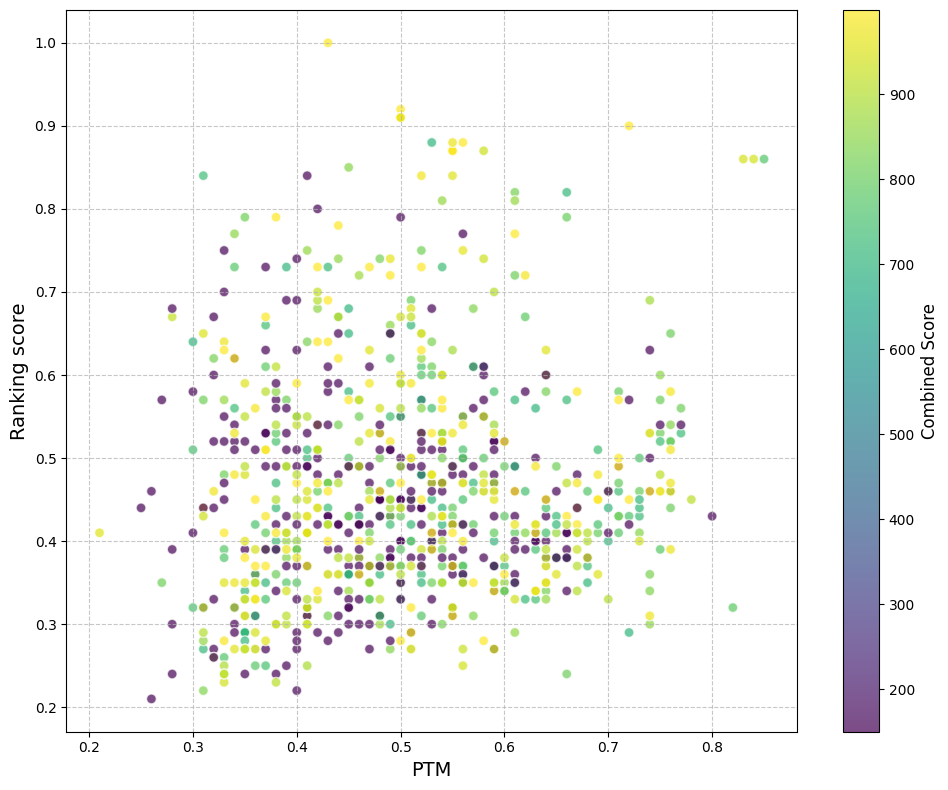

In [ ]:
# Create a scatter plot of iptm vs ptm colored by combined_Score
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    x=results_df_STRING_matched['ptm'], 
    y=results_df_STRING_matched['iptm'], 
    c=results_df_STRING_matched['combined_Score'],
    cmap='viridis',
    alpha=0.7,
    s=50,  # Point size
    edgecolors='w'  # White edge to make points stand out
)

# Add a color bar to show the scale of combined_Score
cbar = plt.colorbar(scatter)
cbar.set_label('Combined Score (STRING)', fontsize=12)

# Add labels and title
plt.xlabel('PTM', fontsize=14)
plt.ylabel('IPTM', fontsize=14)
plt.title('Scatter Plot of IPTM vs PTM Colored by Combined Score (STRING)', fontsize=16)

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Improve the appearance
plt.tight_layout()
plt.show()

In [63]:
def create_scatter_plot(df: pd.DataFrame, x_metric: str, y_metric: str, color_metric: str, 
                       cmap: str = 'viridis', alpha: float = 0.7, size: int = 50) -> None:
    """Create a scatter plot with two metrics and color by a third metric.
    
    This function creates a scatter plot between two specified metrics with points colored
    by a third metric. It's useful for visualizing relationships between different metrics
    like iptm, ptm, and combined_Score.

    Args:
        df (pd.DataFrame): DataFrame containing the metrics to plot
        x_metric (str): Name of the column to plot on x-axis
        y_metric (str): Name of the column to plot on y-axis
        color_metric (str): Name of the column to use for point colors
        cmap (str, optional): Matplotlib colormap name. Defaults to 'viridis'.
        alpha (float, optional): Transparency of points. Defaults to 0.7.
        size (int, optional): Point size. Defaults to 50.
    """
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        x=df[x_metric], 
        y=df[y_metric], 
        c=df[color_metric],
        cmap=cmap,
        alpha=alpha,
        s=size,
        edgecolors='w'  # White edge to make points stand out
    )

    # Add a color bar to show the scale of the color metric
    cbar = plt.colorbar(scatter)
    cbar.set_label(color_metric, fontsize=12)

    # Add labels and title
    plt.xlabel(x_metric, fontsize=14)
    plt.ylabel(y_metric, fontsize=14)
    plt.title(f'Scatter Plot of {y_metric} vs {x_metric} Colored by {color_metric}', fontsize=16)

    # Add a grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)

    # Improve the appearance
    plt.tight_layout()
    plt.show()

In [ ]:
# Create scatter plots using the new function

# 1. Recreate the original plot (iptm vs ptm colored by combined_Score)
create_scatter_plot(results_df_STRING_matched, 'ptm', 'iptm', 'combined_score')

# 2. Create ptm vs ranking_score colored by combined_Score
create_scatter_plot(results_df_STRING_matched, 'ranking_score', 'ptm', 'combined_score')

# 3. Create iptm vs ranking_score colored by combined_Score
create_scatter_plot(results_df_STRING_matched, 'ranking_score', 'iptm', 'combined_score')

KeyError: 'combined_Score'

<Figure size 1000x800 with 0 Axes>